In [1]:
import bz2
import json
import re
import random
import sys
import os
import bz2
import time
import pandas as pd
import numpy as np
from functools import partial
import seaborn as sns
from helpers import *

import bz2
import json
import csv

import seaborn as sns
from helpers import PERSONALITY_ATTRS
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('ggplot')

from ipywidgets import widgets, interactive
from io import StringIO
import math
import plotly.express as px

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

In [2]:
liwc_df = pd.read_csv('data/top_1000_output_1.csv')

In [3]:
liwc_df.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
664,Q7441250,Steve Grogan was my hero. He never got his du...,948,20.61,12.87,70.36,11.18,2.11,3.16,5.27,...,5.59,0.0,0.0,0.21,0.21,1.79,0.0,2.74,3.8,0.42


In [4]:
personality_df = predict_personality(liwc_df)

In [5]:
with open('data/local_only/top-1000-wikidata-occupation-merged_1639495842765.json', 'r', encoding='utf-8') as f:
    wikidata_json = json.load(f)

In [6]:
wikidata_json['Q357994']

{'item': 'Q357994',
 'itemLabel': 'Roberto Martínez',
 'genderLabel': 'male',
 'citizenshipLabel': 'Spain',
 'dateOfBirth': '1973-07-13T00:00:00Z',
 'occupationLabel': 'association football player'}

In [73]:
df1 = pd.concat([liwc_df, personality_df], axis=1)
wikidata_df = pd.DataFrame(wikidata_json.values())

premain_df = df1.merge(wikidata_df, left_on='Source (A)', right_on='item', how='left')
premain_df.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,item,itemLabel,genderLabel,citizenshipLabel,languageLabel,religionLabel,ethnicLabel,dateOfBirth,occupationLabel,degreeLabel
893,Q437993,I wouldn't expect him to go straight into the...,853,26.66,24.03,63.54,6.45,1.06,0.82,1.88,...,Q437993,Neil Lennon,male,United Kingdom,NaN,NaN,NaN,1971-06-25T00:00:00Z,association football player,NaN


In [74]:
def de_list(series, columns):
    for col in columns:
        while isinstance(series[col], list):
            series[col] = series[col][0]
    return series

In [79]:
DEFAULT_VALUE = 'no value'

def remove_nan(series, columns):
    for col in columns:
        if ((isinstance(series[col], int) or isinstance(series[col], float)) and math.isnan(series[col])):
            series[col] = DEFAULT_VALUE
    return series

In [80]:
premain_df = premain_df.apply(de_list, columns=premain_df.columns, axis=1)
premain_df = premain_df.apply(remove_nan, columns=premain_df.columns, axis=1)

## Clustering based on personality attributes

In [157]:
COLUMNS_OF_INTEREST = ['item', 'itemLabel', 'genderLabel', 'citizenshipLabel', 'religionLabel', 'religionLabel', 'dateOfBirth', 'occupationLabel', 'degreeLabel'] + PERSONALITY_ATTRS

In [158]:
main_df = premain_df[COLUMNS_OF_INTEREST].copy()
main_df.sample()

,item,itemLabel,genderLabel,citizenshipLabel,religionLabel,religionLabel,dateOfBirth,occupationLabel,degreeLabel,neuroticism,...,cooperation,modesty,sympathy,conscientiousness,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness
367,Q1335436,Jeff Smith,male,United States of America,no value,no value,1960-02-27T00:00:00Z,animator,no value,0.59644,...,3.693394,0.907411,2.007188,-1.076331,2.227281,0.414256,1.562468,-1.027469,-1.265446,0.818929


In [159]:
# main_df = main_df.head(100).copy()

In [160]:
persattrs = main_df[PERSONALITY_ATTRS]
main_df[PERSONALITY_ATTRS] = (persattrs - persattrs.mean()) / persattrs.std()

In [161]:
clustering = DBSCAN(eps=2).fit(main_df[PERSONALITY_ATTRS])

In [162]:
def percentage_score(arr):
    score = 0
    for val in np.unique(arr):
        tmp = len(arr[arr == val])
        if tmp > score:
            score = tmp
    return main_df.shape[0] - score

In [167]:
lower_score = 1
lower_eps = 1
upper_score = 1
upper_eps = 13

for i in range(20):
    mid_eps = (lower_eps + upper_eps) / 2.0
    test = DBSCAN(eps=mid_eps).fit(main_df[PERSONALITY_ATTRS])
    clusters = np.unique(test.labels_)
    mid_score = len(clusters)
    mid_score = percentage_score(test.labels_)
    mid_score = len(test.labels_[test.labels_ == -1])
    mid_score = 1_000_000 - (mid_score - 0.1 * main_df.shape[0]) ** 2
    print(f'{"eps:":5}{mid_eps:5}\tnumber of clusters: {mid_score}\tnumber of clusters: {len(clusters)}')
    
    mid_plus = mid_eps + (upper_eps - mid_eps) * 0.1
    mid_minus = mid_eps - (mid_eps - lower_eps) * 0.1
    
    mid_plus_test = DBSCAN(eps=mid_plus).fit(main_df[PERSONALITY_ATTRS])
    mid_minus_test = DBSCAN(eps=mid_minus).fit(main_df[PERSONALITY_ATTRS])
    
    mid_plus_score = len(np.unique(mid_plus_test.labels_))
    mid_plus_score = percentage_score(mid_plus_test.labels_)
    mid_plus_score = len(mid_plus_test.labels_[mid_plus_test.labels_ == -1])
    mid_plus_score = 1_000_000 - (mid_plus_score - 0.1 * main_df.shape[0]) ** 2
    
    mid_minus_score = len(np.unique(mid_minus_test.labels_))
    mid_minus_score = percentage_score(mid_minus_test.labels_)
    mid_minus_score = len(mid_minus_test.labels_[mid_minus_test.labels_ == -1])
    mid_minus_score = 1_000_000 - (mid_minus_score - 0.1 * main_df.shape[0]) ** 2
    
    print(f'plus: {mid_plus_score}\tminus: {mid_minus_score}')
    
    if mid_plus_score > mid_minus_score:
        print('plus')
        lower_eps = mid_eps
        lower_score = mid_score
    else:
        print('minus')
        upper_eps = mid_eps
        upper_score = mid_score

eps:   7.0	number of clusters: 990199.0	number of clusters: 2
plus: 990199.0	minus: 990396.0
minus
eps:   4.0	number of clusters: 995904.0	number of clusters: 2
plus: 993759.0	minus: 997696.0
minus
eps:   2.5	number of clusters: 938991.0	number of clusters: 4
plus: 978391.0	minus: 883036.0
plus
eps:  3.25	number of clusters: 999900.0	number of clusters: 3
plus: 999775.0	minus: 999984.0
minus
eps: 2.875	number of clusters: 996156.0	number of clusters: 3
plus: 997296.0	minus: 993600.0
plus
eps: 3.0625	number of clusters: 999676.0	number of clusters: 2
plus: 999744.0	minus: 999676.0
plus
eps: 3.15625	number of clusters: 999984.0	number of clusters: 2
plus: 999984.0	minus: 999984.0
minus
eps: 3.109375	number of clusters: 999856.0	number of clusters: 2
plus: 999951.0	minus: 999804.0
plus
eps: 3.1328125	number of clusters: 999984.0	number of clusters: 2
plus: 999984.0	minus: 999984.0
minus
eps: 3.12109375	number of clusters: 999964.0	number of clusters: 2
plus: 999964.0	minus: 999964.0
minus

In [168]:
# clustering = DBSCAN(eps=1.9375).fit(main_df[PERSONALITY_ATTRS])
# clustering = DBSCAN(eps=2.2890625).fit(main_df[PERSONALITY_ATTRS])
clustering = DBSCAN(eps=3.1328125).fit(main_df[PERSONALITY_ATTRS])

# clustering = DBSCAN(eps=1.48046875).fit(main_df[PERSONALITY_ATTRS])
# clustering = DBSCAN(eps=1.421875).fit(main_df[PERSONALITY_ATTRS])

In [169]:
clustering.labels_

array([ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1,  0,
        0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,
        0,  0, -1,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [170]:
coordinates = TSNE().fit_transform(main_df[PERSONALITY_ATTRS])
# coordinates = TSNE().fit_transform(clustering.labels_.reshape(-1, 1))

In [171]:
main_df['clusterLabel'] = clustering.labels_

In [172]:
main_df['coordinate_x'] = coordinates[:, 0]
main_df['coordinate_y'] = coordinates[:, 1]

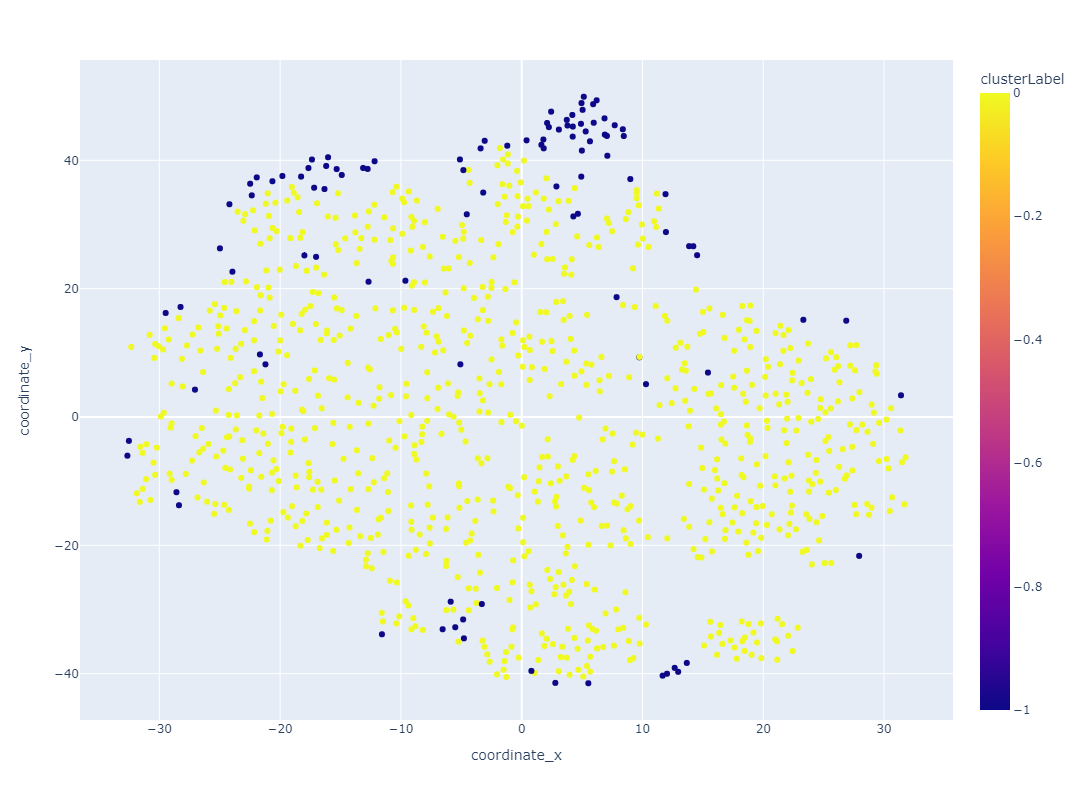

In [173]:
fig = px.scatter(
    main_df, 
    x='coordinate_x', 
    y='coordinate_y', 
    hover_name='itemLabel', 
#     hover_data=['genderLabel', 'citizenshipLabel', 'religionLabel', 'occupationLabel', 'degreeLabel', 'dateOfBirth'], 
    hover_data=['genderLabel', 'citizenshipLabel', 'occupationLabel', 'degreeLabel', 'dateOfBirth'],
    color = 'clusterLabel', 
    size_max=60
)
fig.update_layout(
     height=800)
fig.show()

## Clustering based on word categories

In [174]:
WORD_COLUMNS = list(liwc_df.columns)[2:]

In [175]:
print(WORD_COLUMNS)

['WC', 'WPS', 'Sixltr', 'Dic', 'Pronoun', 'I', 'We', 'Self', 'You', 'Other', 'Negate', 'Assent', 'Article', 'Preps', 'Number', 'Affect', 'Posemo', 'Posfeel', 'Optim', 'Negemo', 'Anx', 'Anger', 'Sad', 'Cogmech', 'Cause', 'Insight', 'Discrep', 'Inhib', 'Tentat', 'Certain', 'Senses', 'See', 'Hear', 'Feel', 'Social', 'Comm', 'Othref', 'Friends', 'Family', 'Humans', 'Time', 'Past', 'Present', 'Future', 'Space', 'Up', 'Down', 'Incl', 'Excl', 'Motion', 'Occup', 'School', 'Job', 'Achieve', 'Leisure', 'Home', 'Sports', 'TV', 'Music', 'Money', 'Metaph', 'Relig', 'Death', 'Physcal', 'Body', 'Sexual', 'Eating', 'Sleep', 'Groom', 'Swear', 'Nonfl', 'Fillers', 'AllPunc', 'Period', 'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote', 'Apostro', 'Parenth', 'OtherP']


In [176]:
COLUMNS_OF_INTEREST = ['item', 'itemLabel', 'genderLabel', 'citizenshipLabel', 'religionLabel', 'dateOfBirth', 'occupationLabel', 'degreeLabel'] + WORD_COLUMNS

In [177]:
main_df = premain_df[COLUMNS_OF_INTEREST].copy()
main_df.sample()

,item,itemLabel,genderLabel,citizenshipLabel,religionLabel,dateOfBirth,occupationLabel,degreeLabel,WC,WPS,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
226,Q608839,Barry Trotz,male,Canada,NaN,1962-07-15T00:00:00Z,ice hockey player,NaN,959,14.53,...,4.69,0.0,0.0,0.1,0.0,0.52,0.0,6.05,0.42,2.09


In [178]:
lower_score = 1
lower_eps = 1
upper_score = 1
upper_eps = 13

for i in range(20):
    mid_eps = (lower_eps + upper_eps) / 2.0
    test = DBSCAN(eps=mid_eps).fit(main_df[WORD_COLUMNS])
    clusters = np.unique(test.labels_)
    mid_score = len(clusters)
    mid_score = percentage_score(test.labels_)
    print(f'{"eps:":5}{mid_eps:5}\tnumber of clusters: {mid_score}\tnumber of clusters: {len(clusters)}')
    
    mid_plus = mid_eps + (upper_eps - mid_eps) * 0.1
    mid_minus = mid_eps - (mid_eps - lower_eps) * 0.1
    
    mid_plus_test = DBSCAN(eps=mid_plus).fit(main_df[WORD_COLUMNS])
    mid_minus_test = DBSCAN(eps=mid_minus).fit(main_df[WORD_COLUMNS])
    
    mid_plus_score = len(np.unique(mid_plus_test.labels_))
    mid_plus_score = percentage_score(mid_plus_test.labels_)
    mid_minus_score = len(np.unique(mid_minus_test.labels_))
    mid_minus_score = percentage_score(mid_minus_test.labels_)
    print(f'plus: {mid_plus_score}\tminus: {mid_minus_score}')
    
    if mid_plus_score > mid_minus_score:
        print('plus')
        lower_eps = mid_eps
        lower_score = mid_score
    else:
        print('minus')
        upper_eps = mid_eps
        upper_score = mid_score

eps:   7.0	number of clusters: 5	number of clusters: 2
plus: 79	minus: 0
plus
eps:  10.0	number of clusters: 276	number of clusters: 2
plus: 235	minus: 321
minus
eps:   8.5	number of clusters: 371	number of clusters: 12
plus: 415	minus: 317
plus
eps:  9.25	number of clusters: 421	number of clusters: 4
plus: 406	minus: 432
minus
eps: 8.875	number of clusters: 485	number of clusters: 6
plus: 496	minus: 477
plus
eps: 9.0625	number of clusters: 544	number of clusters: 4
plus: 476	minus: 532
minus
eps: 8.96875	number of clusters: 510	number of clusters: 6
plus: 513	minus: 508
plus
eps: 9.015625	number of clusters: 524	number of clusters: 5
plus: 527	minus: 524
plus
eps: 9.0390625	number of clusters: 532	number of clusters: 4
plus: 532	minus: 531
plus
eps: 9.05078125	number of clusters: 538	number of clusters: 4
plus: 539	minus: 538
plus
eps: 9.056640625	number of clusters: 540	number of clusters: 4
plus: 540	minus: 540
minus
eps: 9.0537109375	number of clusters: 539	number of clusters: 4
pl

In [179]:
clustering = DBSCAN(eps=8.5).fit(main_df[WORD_COLUMNS])
# clustering = DBSCAN(eps=9.056640625).fit(main_df[WORD_COLUMNS])

In [180]:
coordinates = TSNE().fit_transform(main_df[WORD_COLUMNS])
# coordinates = TSNE().fit_transform(clustering.labels_.reshape(-1, 1))

In [181]:
main_df['clusterLabel'] = clustering.labels_

In [182]:
main_df['coordinate_x'] = coordinates[:, 0]
main_df['coordinate_y'] = coordinates[:, 1]

In [209]:
main_df[main_df['genderLabel'] == 'male'].shape

(897, 95)

In [210]:
main_df[main_df['genderLabel'] == 'female'].shape

(97, 95)

In [217]:
anders = (main_df['genderLabel'] == 'male') & (main_df['genderLabel'] == 'female')
noters = ~anders
main_df[noters].shape

(1000, 95)

In [208]:
from plotly.validators.scatter.marker import SymbolValidator

SYMBOL_COLUMN_NAME = 'genderLabel'

raw_symbols = SymbolValidator().values
unique_list = main_df[SYMBOL_COLUMN_NAME].unique()
print(len(unique_list))

symbol_map = dict()
for index, val in enumerate(unique_list):
    symbol_map[val] = raw_symbols[index]
    
symbol_list = []
for index, row in main_df.iterrows():
    symbol_list.append(symbol_map[row[SYMBOL_COLUMN_NAME]])

TypeError: unhashable type: 'list'

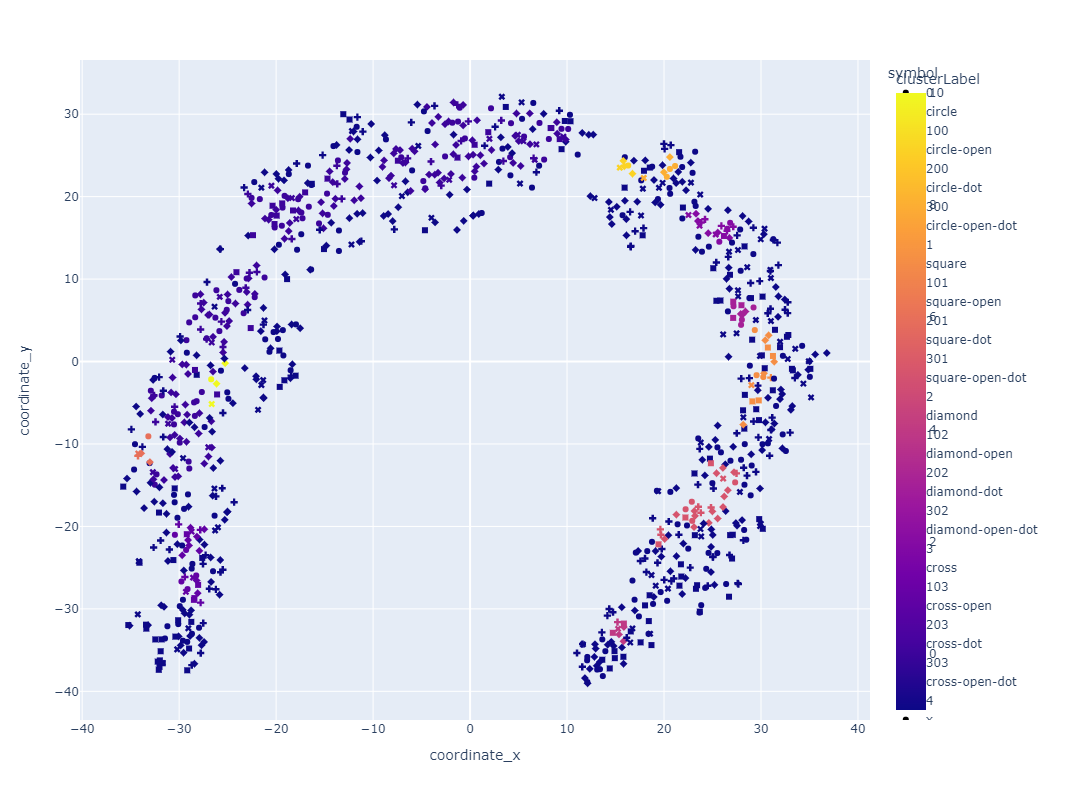

In [206]:
fig = px.scatter(
    main_df, 
    x='coordinate_x', 
    y='coordinate_y', 
    hover_name='itemLabel', 
    hover_data=['genderLabel', 'citizenshipLabel', 'religionLabel', 'occupationLabel', 'degreeLabel', 'dateOfBirth'], 
    color = 'clusterLabel',
    symbol = symbol_list,
    size_max=60
)
fig.update_layout(
     height=800)
fig.show()

In [192]:
import plotly.graph_objects as go

def multi_scatter(column_name):
    # Build figure
    fig = go.Figure()

    # Add scatter trace with medium sized markers
    fig.add_trace(
        go.Scatter(
            mode='markers',
            x=main_df['coordinate_x'],
            y=main_df['coordinate_y'],
            marker=dict(
                color='LightSkyBlue',
                size=120,
                line=dict(
                    color='MediumPurple',
                    width=12
                )
            ),
            showlegend=False
        )
    )

    # Add trace with large marker
#     fig.add_trace(
#         go.Scatter(
#             mode='markers',
#             x=[2],
#             y=[4.5],
#             marker=dict(
#                 color='LightSkyBlue',
#                 size=120,
#                 line=dict(
#                     color='MediumPurple',
#                     width=12
#                 )
#             ),
#             showlegend=False
#         )
#     )

    fig.show()

In [193]:
multi_scatter('asd')

ValueError: Invalid property specified for object of type plotly.graph_objs.Scatter: 'color'

Did you mean "fill"?

    Valid properties:
        cliponaxis
            Determines whether or not markers and text nodes are
            clipped about the subplot axes. To show markers and
            text nodes above axis lines and tick labels, make sure
            to set `xaxis.layer` and `yaxis.layer` to *below
            traces*.
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            `customdata`.
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        error_x
            :class:`plotly.graph_objects.scatter.ErrorX` instance
            or dict with compatible properties
        error_y
            :class:`plotly.graph_objects.scatter.ErrorY` instance
            or dict with compatible properties
        fill
            Sets the area to fill with a solid color. Defaults to
            "none" unless this trace is stacked, then it gets
            "tonexty" ("tonextx") if `orientation` is "v" ("h") Use
            with `fillcolor` if not "none". "tozerox" and "tozeroy"
            fill to x=0 and y=0 respectively. "tonextx" and
            "tonexty" fill between the endpoints of this trace and
            the endpoints of the trace before it, connecting those
            endpoints with straight lines (to make a stacked area
            graph); if there is no trace before it, they behave
            like "tozerox" and "tozeroy". "toself" connects the
            endpoints of the trace (or each segment of the trace if
            it has gaps) into a closed shape. "tonext" fills the
            space between two traces if one completely encloses the
            other (eg consecutive contour lines), and behaves like
            "toself" if there is no trace before it. "tonext"
            should not be used if one trace does not enclose the
            other. Traces in a `stackgroup` will only fill to (or
            be filled to) other traces in the same group. With
            multiple `stackgroup`s or some traces stacked and some
            not, if fill-linked traces are not already consecutive,
            the later ones will be pushed down in the drawing
            order.
        fillcolor
            Sets the fill color. Defaults to a half-transparent
            variant of the line color, marker color, or marker line
            color, whichever is available.
        groupnorm
            Only relevant when `stackgroup` is used, and only the
            first `groupnorm` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the normalization for the sum of
            this `stackgroup`. With "fraction", the value of each
            trace at each location is divided by the sum of all
            trace values at that location. "percent" is the same
            but multiplied by 100 to show percentages. If there are
            multiple subplots, or multiple `stackgroup`s on one
            subplot, each will be normalized within its own set.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            `hoverinfo`.
        hoverlabel
            :class:`plotly.graph_objects.scatter.Hoverlabel`
            instance or dict with compatible properties
        hoveron
            Do the hover effects highlight individual points
            (markers or line points) or do they highlight filled
            regions? If the fill is "toself" or "tonext" and there
            are no markers or text, then the default is "fills",
            otherwise it is "points".
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. The variables available in
            `hovertemplate` are the ones emitted as event data
            described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `hovertemplate`.
        hovertext
            Sets hover text elements associated with each (x,y)
            pair. If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (x,y)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            `hovertext`.
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            `ids`.
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.scatter.Legendgrouptitle`
            instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with `*reversed* `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items.
        line
            :class:`plotly.graph_objects.scatter.Line` instance or
            dict with compatible properties
        marker
            :class:`plotly.graph_objects.scatter.Marker` instance
            or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes "text" then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover. If there are less than
            20 points and the trace is not stacked then the default
            is "lines+markers". Otherwise, "lines".
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        orientation
            Only relevant when `stackgroup` is used, and only the
            first `orientation` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the stacking direction. With "v"
            ("h"), the y (x) values of subsequent traces are added.
            Also affects the default value of `fill`.
        selected
            :class:`plotly.graph_objects.scatter.Selected` instance
            or dict with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stackgaps
            Only relevant when `stackgroup` is used, and only the
            first `stackgaps` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Determines how we handle locations at
            which other traces in this group have data but this one
            does not. With *infer zero* we insert a zero at these
            locations. With "interpolate" we linearly interpolate
            between existing values, and extrapolate a constant
            beyond the existing values.
        stackgroup
            Set several scatter traces (on the same subplot) to the
            same stackgroup in order to add their y values (or
            their x values if `orientation` is "h"). If blank or
            omitted this trace will not be stacked. Stacking also
            turns `fill` on by default, using "tonexty" ("tonextx")
            if `orientation` is "h" ("v") and sets the default
            `mode` to "lines" irrespective of point count. You can
            only stack on a numeric (linear or log) axis. Traces in
            a `stackgroup` will only fill to (or be filled to)
            other traces in the same group. With multiple
            `stackgroup`s or some traces stacked and some not, if
            fill-linked traces are not already consecutive, the
            later ones will be pushed down in the drawing order.
        stream
            :class:`plotly.graph_objects.scatter.Stream` instance
            or dict with compatible properties
        text
            Sets text elements associated with each (x,y) pair. If
            a single string, the same string appears over all the
            data points. If an array of string, the items are
            mapped in order to the this trace's (x,y) coordinates.
            If trace `hoverinfo` contains a "text" flag and
            "hovertext" is not set, these elements will be seen in
            the hover labels.
        textfont
            Sets the text font.
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textpositionsrc
            Sets the source reference on Chart Studio Cloud for
            `textposition`.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            `text`.
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. Every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.
        texttemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `texttemplate`.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        unselected
            :class:`plotly.graph_objects.scatter.Unselected`
            instance or dict with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xhoverformat
            Sets the hover text formatting rulefor `x`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `xaxis.hoverformat`.
        xperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the x
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        xperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the x0 axis. When `x0period` is round number
            of weeks, the `x0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        xperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the x axis.
        xsrc
            Sets the source reference on Chart Studio Cloud for
            `x`.
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        yhoverformat
            Sets the hover text formatting rulefor `y`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `yaxis.hoverformat`.
        yperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the y
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        yperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the y0 axis. When `y0period` is round number
            of weeks, the `y0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        yperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the y axis.
        ysrc
            Sets the source reference on Chart Studio Cloud for
            `y`.
        
Did you mean "fill"?

Bad property path:
color
^^^^^